# Gibbs sampling and mean field VB for the probit model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [59]:
data = pd.read_table('german_data_numeric.txt', header=None, delim_whitespace=True)
n, p = data.shape

y  = data[p-1].apply(lambda x: 1 if x==1 else -1).values
X0 = data.iloc[:,:-1].values

### Q1. Normalization

In [60]:
# Scaling the data
mean, std = np.mean(X0, axis=0), np.std(X0, axis=0)
X = (X0-mean)/std

# Add a bias to the data matrix
X = np.concatenate((np.ones((n,1)),X), axis=1)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Q3. Bayesian inference with Gibbs sampling

Gibbs sampling boils down to the following:

* sample $\beta^{t+1} \sim p(\beta|z^t) = \mathcal N(\mu^t, \Sigma)$ where $$\Sigma = (\frac1\tau I_p + X^TX)^{-1}\quad \text{and}\quad \mu^t = \Sigma X^Tz^t \in \mathbb R^p $$

* sample $z^{t+1} \sim p(z|\beta^{t+1},y^t) = \exp(-\frac12\|z-X\beta^{t+1}\|^2) \prod_i \mathbf{1}_{\{y_i^{t}z_i > 0\}}$

* sample $y^{t+1} \sim p(y|z^{t+1}) = \mathrm{Ber}\left(\Phi(\beta_i^{t+1,T}x_i)\right)$

In [94]:
import time
from scipy.stats import truncnorm

In [286]:
def sample_truncated_gaussian(mean, y, size=None):
    """
    Sample a vector of truncated Gaussians z with means
    mean[i] and in the support z[i]y[i] > 0.
    """
    dim = len(mean)
    a = -mean
    b = -mean
    a[y < 0] = -np.inf
    b[y > 0] = np.inf
    if size is not None:
        size = (size, dim)
    z = truncnorm.rvs(a, b, loc=mean, size=size)
    return z

In [211]:
class GibbsSampler():

    def __init__(self, X, y, tau=100, burn_in=4000):
        
        self.n = X.shape[0]
        self.d = X.shape[1]
        
        self.tau = tau
        
        self.burn_in   = burn_in
        self.burned_in = False
        
        # posterior beta|z precision matrix
        self.precision  = np.eye(self.d)/tau + np.dot(X.T,X)  
        self.covariance = np.linalg.pinv(self.precision)  
        
        self.mu = np.zeros((self.d,))
        self.mu_samples = []

        self.beta = np.random.randn(self.d) * tau ** .5
        self.beta_samples      = []
  
        self.z = np.random.randn(self.n)
        self.z_samples = []
    
    def draw_samples(self, X, y, num_iterations):
        """
        Draw samples from the posterior distribution.
        Returns: beta_samples, z_samples: samples from the posterior p(beta, z|X, y)
        """
        operator   = np.dot(self.covariance,X.T)
        
        for t in range(num_iterations):
            # Sample beta|z
            self.beta = np.random.multivariate_normal(self.mu,cov=self.covariance)
            mean_posterior = np.dot(X,self.beta)
            
            # Sample z|beta,y
            self.z  = sample_truncated_gaussian(mean=mean_posterior, y=y) 
            self.mu = np.dot(operator,self.z)  
            
            if t >= self.burn_in:
                self.burned_in = True
            
            if self.burned_in:
                self.mu_samples.append(self.mu)
                self.beta_samples.append(self.beta)
                self.z_samples.append(self.z)

        return np.array(self.beta_samples), np.array(self.z_samples)
    
    def predict(self, X, n_samples=None):
        n, d = X.shape
        if n_samples is None:
            n_samples = len(self.beta_samples)
        beta   = np.array(self.beta_samples)[-n_samples:] 
        noise  = np.random.randn(n, n_samples)
        z_pred = np.dot(X, beta.T) + noise  
        return np.sign(z_pred).T
    
    def accuracy(self, y_predict, y_test):
        y_predict_label = 2*(np.mean(y_predict, axis=0)>0)-1
        accuracy = np.mean(y_predict_label == y_test)
        return accuracy

In [212]:
gibbs_sampler = GibbsSampler(X_train, y_train, tau=100, burn_in=100)

In [213]:
t0 = time.time()
gibbs_sampled_beta, gibbs_sampled_z = gibbs_sampler.draw_samples(X_train, y_train, num_iterations=5000 + gibbs_sampler.burn_in)
t_gibbs = time.time() - t0
print("Elapsed time: %.3f" %t_gibbs)

Elapsed time: 2.985


In [214]:
y_predict = gibbs_sampler.predict(X_test)

#### Plots

In [215]:
def plot_(idx, t_max=1000):
    fig = plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.title("$\\beta_{%d}$" % idx)
    plt.plot(np.arange(t_max), gibbs_sampled_beta[:t_max, idx], c='b', lw=1.0)
    
    plt.subplot(1,2,2)
    plt.title("$z_{%d}$" % idx)
    plt.plot(np.arange(t_max), gibbs_sampled_z[:t_max, idx], c='m', lw=1.0)

    fig.tight_layout()
    plt.show()

In [244]:
def plot_gibbs_posterior_marginals(indices):    
    
    fig = plt.figure(figsize=(20,10))
    r = len(indices)
    nrows  = r/2 if r%2==0 else r/2 +1
    ncols  = 4
    n_bins = 50
    hist_opts = dict(rwidth=.88, density=True)

    for i, idx in enumerate(indices):
        plt.subplot(nrows,ncols,2*i+1)
        plt.hist(gibbs_sampled_beta[:, idx], bins=n_bins, **hist_opts, label="Gibbs")
        plt.title("$\\beta_{%d}$" % idx)
        plt.legend()

        plt.subplot(nrows,ncols,2*i+2)
        plt.hist(gibbs_sampled_z[:, idx], bins=n_bins, **hist_opts, label="Gibbs")
        plt.title("$z_{%d}$" % idx)
        plt.legend()

    fig.tight_layout()
    fig.suptitle("Gibbs Posterior marginals", y=1.)
    plt.show()

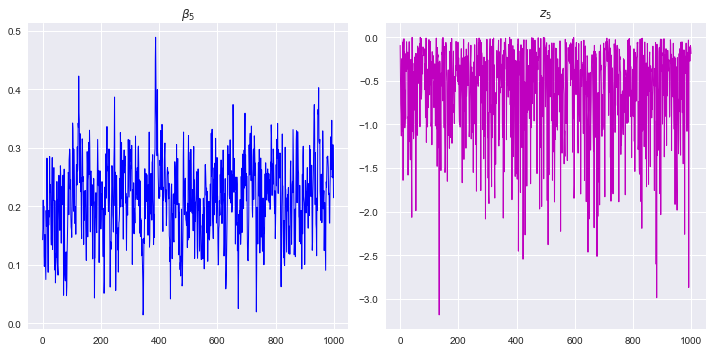

In [245]:
plot_(5)

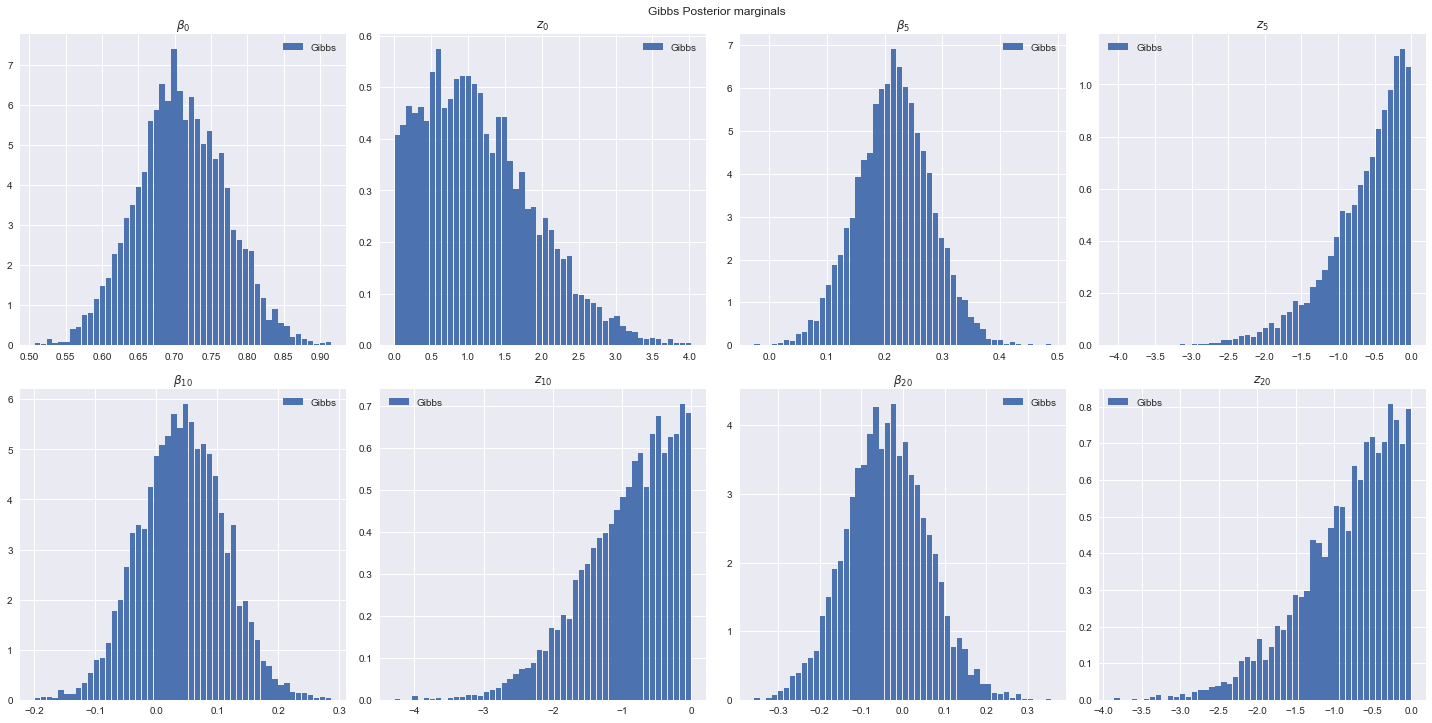

In [246]:
indices = [0,5,10,20]
plot_gibbs_posterior_marginals(indices)

#### Performance

In [219]:
print('Gibbs Accuracy: %.3f' %gibbs_sampler.accuracy(y_predict, y_test))

Gibbs Accuracy: 0.780


### Q4. Mean Field Variational Inference

In [220]:
from scipy.stats import norm

In [221]:
class MeanField:

    def __init__(self, X, y, tau=100):

        self.n = X.shape[0]
        self.d = X.shape[1]
        
        self.tau = tau
        
        self.precision  = np.eye(self.d)/tau + np.dot(X.T,X)  
        self.covariance = np.linalg.pinv(self.precision) 
        
        self.mean_beta = np.random.randn(self.d)  
        self.mean_z    = np.random.rand(self.n)    
        
        self.norm_beta = []
        self.norm_z    = []
        
    def infer(self, X, y, n_iterations):
        
        operator = np.dot(self.covariance,X.T)
        
        for t in range(n_iterations):
            beta = np.dot(operator, self.mean_z)
            self.norm_beta.append(np.linalg.norm(beta - self.mean_beta, ord=1))
            self.mean_beta[:] = beta
            
            z = np.dot(X,self.mean_beta) + y * norm.pdf(np.dot(X,self.mean_beta)) / norm.cdf(y*np.dot(X,self.mean_beta))
            self.norm_z.append(np.linalg.norm(z - self.mean_z, ord=1))
            self.mean_z[:] = z

    def draw_sample(self, y, n_samples):

        sampled_beta = np.random.multivariate_normal(self.mean_beta, cov=self.covariance, size=n_samples)
        sampled_z = sample_truncated_gaussian(self.mean_z, y, size=n_samples)

        return sampled_beta, sampled_z
    
    def predict(self, X, sampled_beta):
        n, d = X.shape
        z = np.dot(X,sampled_beta.T)  
        return np.sign(z.T)
    
    def accuracy(self, y_predict, y_test):
        y_predict_label = 2*(np.mean(y_predict, axis=0)>0)-1
        accuracy = np.mean(y_predict_label == y_test)
        return accuracy

In [222]:
mean_field = MeanField(X_train, y_train)

In [223]:
t0 = time.time()
mean_field.infer(X_train, y_train, n_iterations=200)
mean_field_beta, mean_field_z = mean_field.draw_sample(y_train, n_samples=5000)
t_meanfield = time.time() - t0
print("Elapsed time: %.3f" %t_meanfield)

Elapsed time: 0.340


In [224]:
y_predict = mean_field.predict(X_test, mean_field_beta)

#### Plots

In [242]:
def plot_MF_posterior_marginal(indices):
    
    fig = plt.figure(figsize=(20,10))
    r = len(indices)
    nrows  = r/2 if r%2==0 else r/2 +1
    ncols  = 4
    n_bins = 50
    hist_opts = dict(rwidth=.88, density=True)

    for i, idx in enumerate(indices):
        plt.subplot(nrows,ncols,2*i+1)
        plt.hist(mean_field_beta[:, idx], bins=n_bins, **hist_opts, label="MF VI")
        plt.title("$\\beta_{%d}$" % idx)
        plt.legend()
        
        plt.subplot(nrows,ncols,2*i+2)
        plt.hist(mean_field_z[:, idx], bins=n_bins, **hist_opts, label="MF VI")
        plt.title("$z_{%d}$" % idx)
        plt.legend()
        
    fig.tight_layout()
    fig.suptitle("Mean Field VI Posterior marginals", y=1.)
    plt.show()

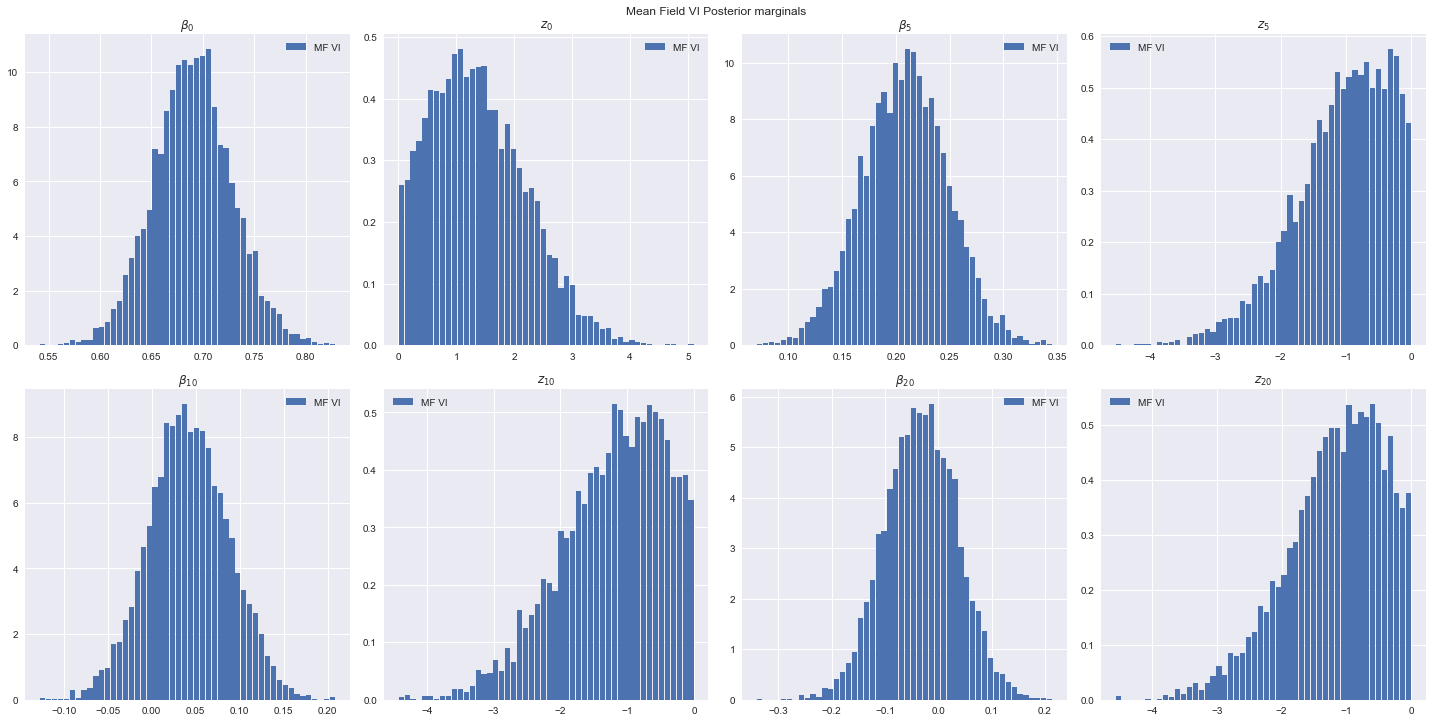

In [243]:
indices = [0,5,10,20]
plot_MF_posterior_marginal(indices)

In [240]:
def Gibbs_vs_MF_posterior_marginal(indices):
    
    fig = plt.figure(figsize=(20, 10))
    r = len(indices)
    nrows  = r/2 if r%2==0 else r/2 +1
    ncols  = 4
    n_bins = 50
    hist_opts = dict(rwidth=.88, density=True)

    for i, idx in enumerate(indices):
        plt.subplot(nrows,ncols,2*i+1)
        plt.hist(mean_field_beta[:, idx], bins=n_bins, **hist_opts, label="MF VI")
        plt.hist(gibbs_sampled_beta[:, idx], bins=n_bins, **hist_opts, label="Gibbs")
        plt.title("$\\beta_{%d}$" % idx)
        plt.legend()
        
        plt.subplot(nrows,ncols,2*i+2)
        plt.hist(mean_field_z[:, idx], bins=n_bins, **hist_opts, label="MF VI")
        plt.hist(gibbs_sampled_z[:, idx], bins=n_bins, **hist_opts, label="Gibbs")
        plt.title("$z_{%d}$" % idx)
        plt.legend()
        
    fig.tight_layout()
    fig.suptitle("Posterior marginals: Gibbs vs Mean Field VI", y=1.)
    plt.show()

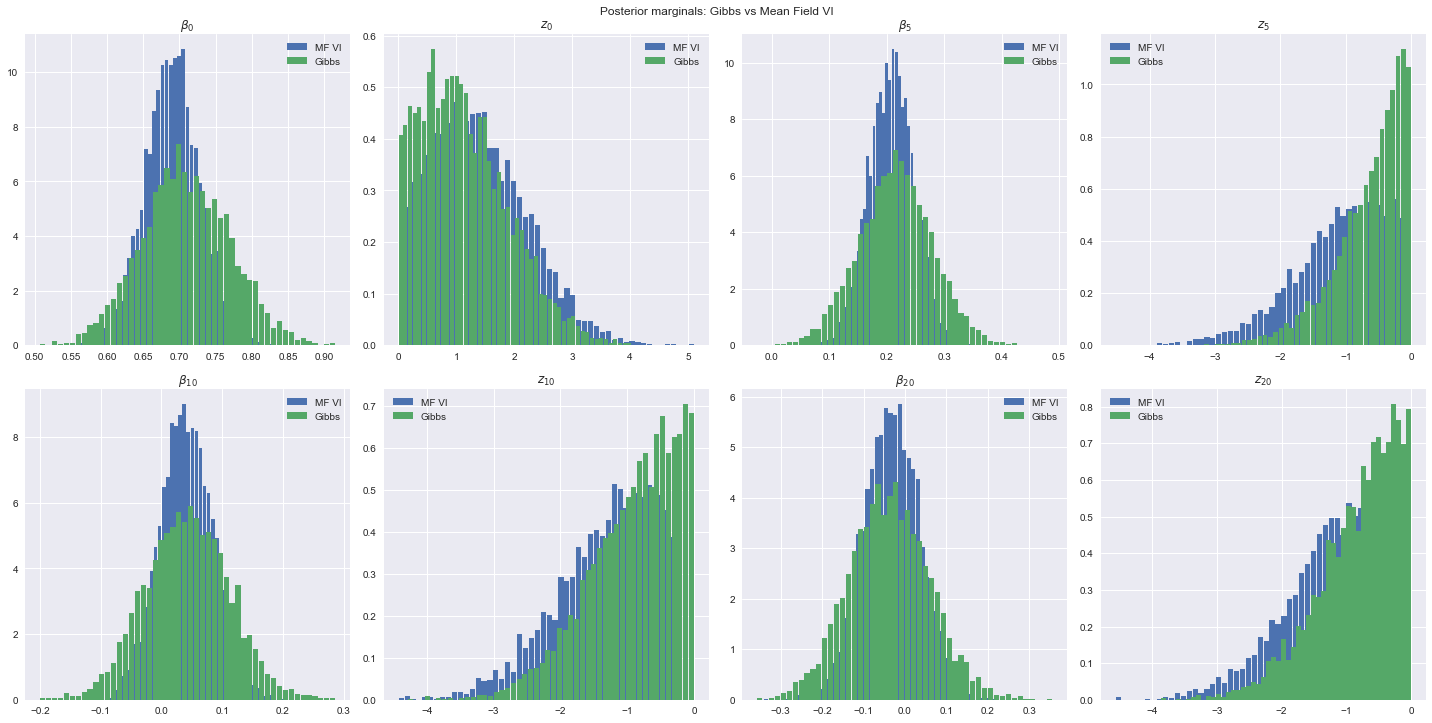

In [241]:
indices = [0,5,10,20]
Gibbs_vs_MF_posterior_marginal(indices)

#### Performance

In [230]:
print('MeanField VI Accuracy: %.3f' %mean_field.accuracy(y_predict, y_test))

MeanField VI Accuracy: 0.777


### Q6. Complete Seperation Application

In [353]:
n, p = 1000, 2

x = np.random.randn(n,p)
y = np.ones((n,))

beta = np.array([2.5, -1.5])
seperator = np.dot(x,beta) + 0.1 > 0.
x1, y1 = x[seperator], y[seperator]
x2, y2 = x[~seperator] - np.array([.5, .4]), y[~seperator]

X = np.vstack([x1, x2])
X = (X-np.mean(X, axis=0))/np.std(X, axis=0)
X = np.hstack([0.001*np.ones((X.shape[0], 1)), X])
y = np.hstack([y1, y2])

X_train, X_test = X[200:], X[:200]
y_train, y_test = y[200:], y[:200]

In [374]:
def plot_data(x1, x2):
    fig = plt.figure(figsize=(7,6))
    plt.scatter(*x1.T, s=20, c='orange', label="$y=1$")
    plt.scatter(*x2.T, s=20, c='b', label="$y=-1$")
    plt.legend()
    line = plt.Line2D([-1, 1], [-1.5, 2.5], c='m')
    ax   = plt.gca(); ax.add_line(line)
    plt.title("Separable data")
    fig.tight_layout()
    plt.show()

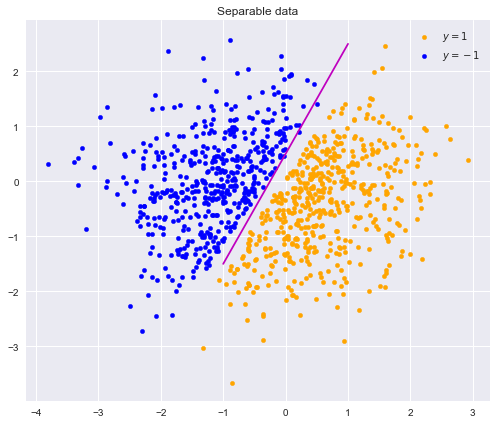

In [375]:
plot_data(x1,x2)

In [356]:
gibbs_sampler_ = GibbsSampler(X_train, y_train, tau=1000, burn_in=100)

In [357]:
t0 = time.time()
gibbs_sampled_beta, gibbs_sampled_z = gibbs_sampler_.draw_samples(X_train, y_train, num_iterations=8000+gibbs_sampler.burn_in)
t_gibbs = time.time() - t0
print("Elapsed time: %.3f" %t_gibbs)

Elapsed time: 3.055


In [358]:
y_predict = gibbs_sampler_.predict(X_test)

In [359]:
def plot_gibbs_posterior_marginals(indices):    
    
    fig = plt.figure(figsize=(20,10))
    r = len(indices)
    nrows  = r/2 if r%2==0 else r/2 +1
    ncols  = 4
    n_bins = 50
    hist_opts = dict(rwidth=.88, density=True)

    for i, idx in enumerate(indices):
        plt.subplot(nrows,ncols,2*i+1)
        plt.hist(gibbs_sampled_beta[:, idx], bins=n_bins, **hist_opts, label="Gibbs")
        plt.title("$\\beta_{%d}$" % idx)
        plt.legend()

        plt.subplot(nrows,ncols,2*i+2)
        plt.hist(gibbs_sampled_z[:, idx], bins=n_bins, **hist_opts, label="Gibbs")
        plt.title("$z_{%d}$" % idx)
        plt.legend()

    fig.tight_layout()
    fig.suptitle("Gibbs Posterior marginals", y=1.)
    plt.show()

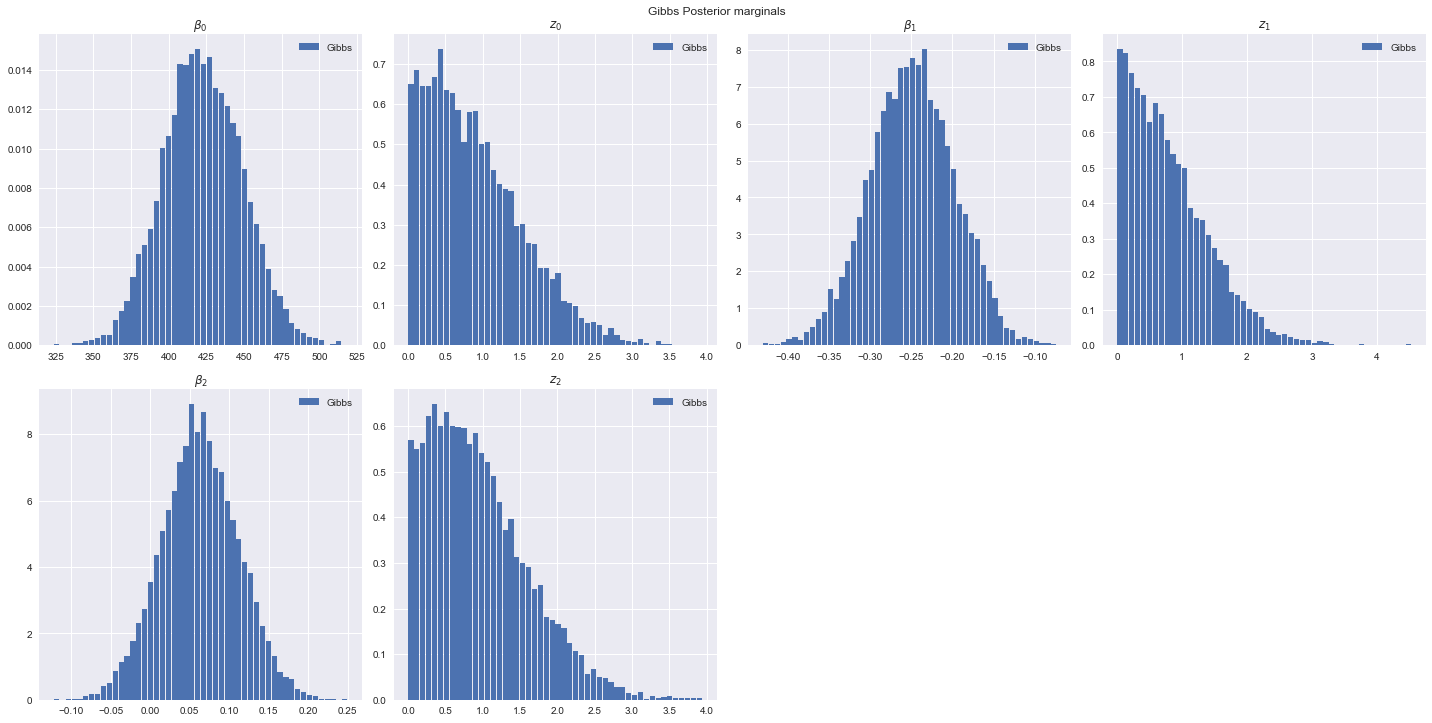

In [360]:
indices = [0,1,2]
plot_gibbs_posterior_marginals(indices)

In [361]:
print('Gibbs Accuracy: %.3f' %gibbs_sampler_.accuracy(y_predict, y_test))

Gibbs Accuracy: 0.895
